# Exam Data

reference book : https://otexts.com/fpp3/index.html


data source: https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=pet&s=emm_epm0_pte_sca_dpg&f=w

In [ ]:
import tensorflow as tf

In [ ]:
import pandas as pd
import numpy as np
import datetime
df=pd.read_csv('gas_price.csv')
df.head()

,Week of,Weekly California All Grades All Formulations Retail Gasoline Prices Dollars per Gallon
0,8/15/2022,5.315
1,8/8/2022,5.391
2,8/1/2022,5.560
3,7/25/2022,5.661
4,7/18/2022,5.794


In [ ]:
df.tail()

,Week of,Weekly California All Grades All Formulations Retail Gasoline Prices Dollars per Gallon
1156,6/19/2000,1.664
1157,6/12/2000,1.662
1158,6/5/2000,1.661
1159,5/29/2000,1.673
1160,5/22/2000,1.679


In [ ]:
df['Week of']=df['Week of'].apply(lambda x: datetime.datetime.strptime(x,'%m/%d/%Y'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1161 entries, 0 to 1160
Data columns (total 2 columns):
 #   Column                                                                                   Non-Null Count  Dtype         
---  ------                                                                                   --------------  -----         
 0   Week of                                                                                  1161 non-null   datetime64[ns]
 1   Weekly California All Grades All Formulations Retail Gasoline Prices Dollars per Gallon  1161 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 18.3 KB


In [ ]:
df.rename(columns={'Week of': 'Date',
                   'Weekly California All Grades All Formulations Retail Gasoline Prices Dollars per Gallon':'Price'},inplace=True)

In [ ]:
price=df[['Date','Price']].set_index('Date')

In [ ]:
price=price.iloc[::-1]
price.head()

,Price
Date,
2000-05-22,1.679
2000-05-29,1.673
2000-06-05,1.661
2000-06-12,1.662
2000-06-19,1.664


# Visualize Data

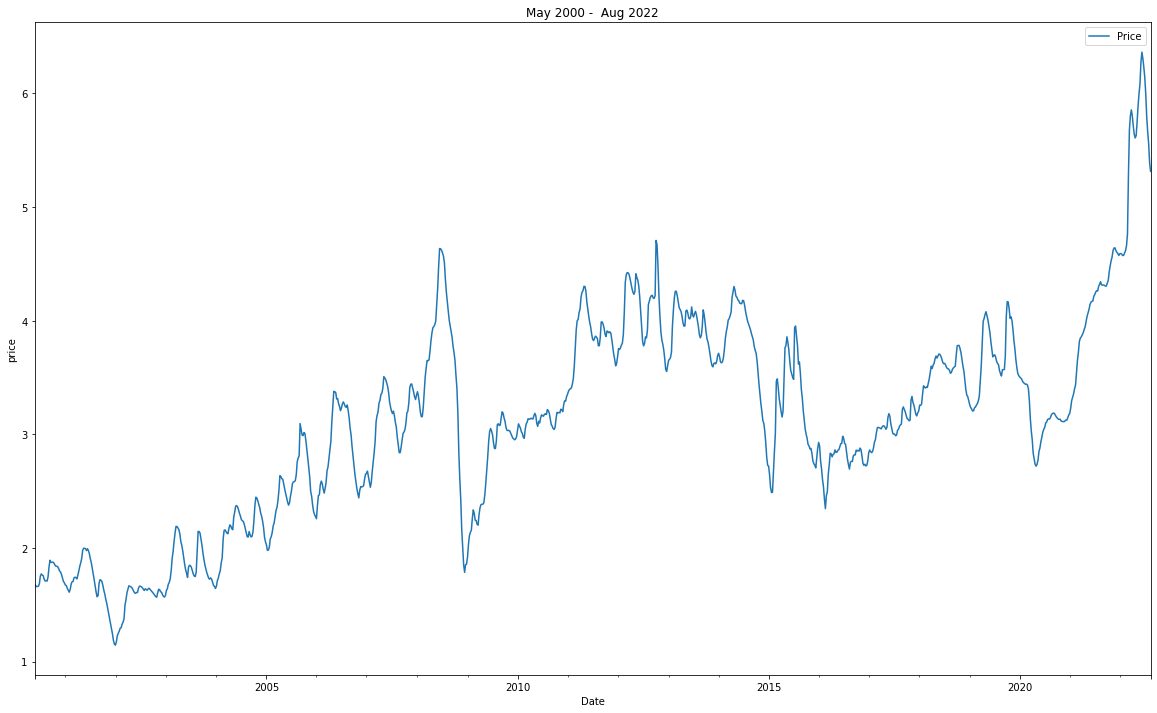

In [ ]:
import matplotlib.pyplot as plt
price.plot(figsize=(20,12))
plt.ylabel('price')
plt.title('May 2000 -  Aug 2022')
plt.show()

# Split Data 

In [ ]:
split=int(0.9*len(price))

In [ ]:
time=price.index.to_numpy()
prices=price['Price'].to_numpy()
prices[:10]

array([1.679, 1.673, 1.661, 1.662, 1.664, 1.687, 1.754, 1.773, 1.763,
       1.756])

In [ ]:
X_train,y_train=time[:split],prices[:split]
X_test,y_test=time[split:],prices[split:]
len(X_train),len(X_test), len(y_test)

(1044, 117, 117)

In [ ]:
def plot_time_series(time, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps  against values .
  """
  # Plot the series
  plt.plot(time[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Price")
  if label:
    plt.legend(fontsize=14) 
  plt.grid(True)

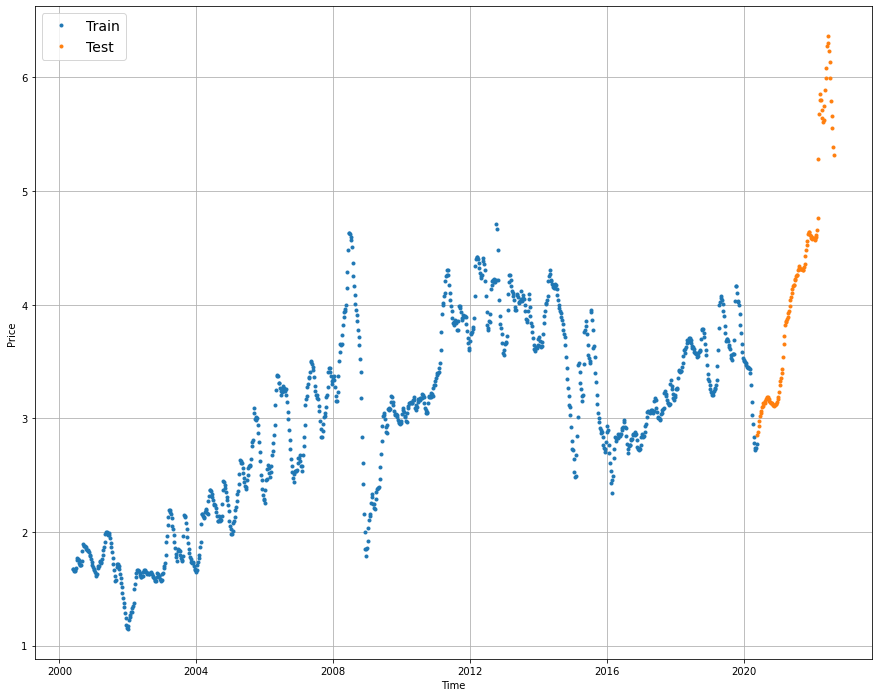

In [ ]:
plt.figure(figsize=(15,12))
plot_time_series(time=X_train, values=y_train,label='Train')
plot_time_series(time=X_test, values=y_test,label='Test')

# Naive Model 

In [ ]:
naive = y_test[:-1] 
print('first 10: ',naive[:10])
print('last 10:',naive[-10:] )

first 10:  [2.85  2.882 2.937 2.976 3.022 3.044 3.063 3.101 3.11  3.132]
last 10: [6.276 6.364 6.307 6.23  6.138 5.994 5.794 5.661 5.56  5.391]


## plot test data and prediction

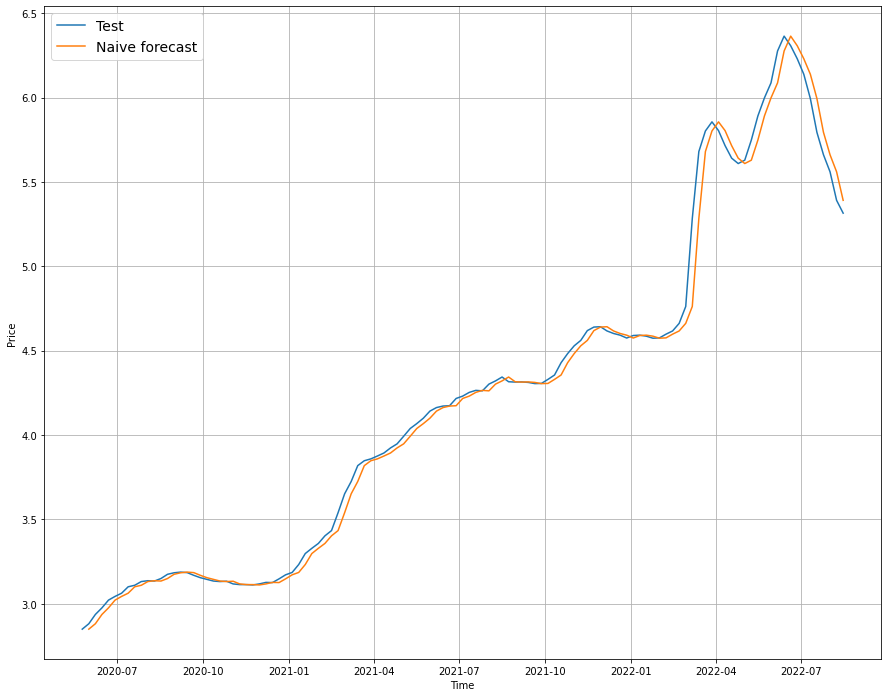

In [ ]:
plt.figure(figsize=(15, 12))
plot_time_series(time=X_test, values=y_test,format='-', label="Test")
plot_time_series(time=X_test[1:], values=naive, format="-", label="Naive forecast");

## zoom in plot

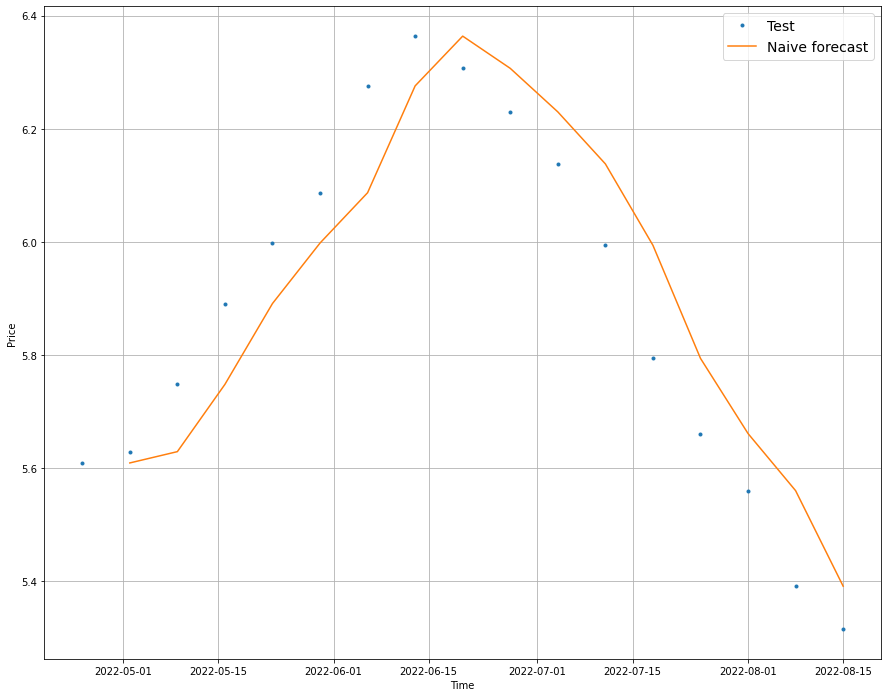

In [ ]:
plt.figure(figsize=(15, 12))
plot_time_series(time=X_test, values=y_test, start=100, label="Test")
plot_time_series(time=X_test[1:], values=naive, format="-", start=100, label="Naive forecast")

#  Define Different Evaluation Metrics

In [ ]:
def evaluate(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred) 
  if mae.ndim>0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

In [ ]:
naive_result=evaluate(y_test[1:],naive)
naive_result

{'mae': 0.04719828, 'mse': 0.00701523, 'rmse': 0.08375697, 'mape': 1.0061721}

In [ ]:
horizon=1
batch_size=32
window=7

In [ ]:
price_window=price.copy()
for i in range(window):
  price_window[f"{i+1} unit ago"] = price_window["Price"].shift(periods=i+1)
price_window.head(10)

,Price,1 unit ago,2 unit ago,3 unit ago,4 unit ago,5 unit ago,6 unit ago,7 unit ago
Date,,,,,,,,
2000-05-22,1.679,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-29,1.673,1.679,NaN,NaN,NaN,NaN,NaN,NaN
2000-06-05,1.661,1.673,1.679,NaN,NaN,NaN,NaN,NaN
2000-06-12,1.662,1.661,1.673,1.679,NaN,NaN,NaN,NaN
2000-06-19,1.664,1.662,1.661,1.673,1.679,NaN,NaN,NaN
2000-06-26,1.687,1.664,1.662,1.661,1.673,1.679,NaN,NaN
2000-07-03,1.754,1.687,1.664,1.662,1.661,1.673,1.679,NaN
2000-07-10,1.773,1.754,1.687,1.664,1.662,1.661,1.673,1.679
2000-07-17,1.763,1.773,1.754,1.687,1.664,1.662,1.661,1.673


In [ ]:
X = price_window.dropna().drop("Price", axis=1).astype(np.float32) 
y = price_window.dropna()["Price"].astype(np.float32)
X.head()

,1 unit ago,2 unit ago,3 unit ago,4 unit ago,5 unit ago,6 unit ago,7 unit ago
Date,,,,,,,
2000-07-10,1.754,1.687,1.664,1.662,1.661,1.673,1.679
2000-07-17,1.773,1.754,1.687,1.664,1.662,1.661,1.673
2000-07-24,1.763,1.773,1.754,1.687,1.664,1.662,1.661
2000-07-31,1.756,1.763,1.773,1.754,1.687,1.664,1.662
2000-08-07,1.726,1.756,1.763,1.773,1.754,1.687,1.664


In [ ]:
y.head()

Date
2000-07-10    1.773
2000-07-17    1.763
2000-07-24    1.756
2000-07-31    1.726
2000-08-07    1.710
Name: Price, dtype: float32

In [ ]:
X.shape, y.shape

((1154, 7), (1154,))

# Split Windowed Data

In [ ]:
split_size = int(len(X) * 0.9)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1038, 7), (1038,), (116, 7), (116,))

# Create Checkpoint

In [ ]:
import os
def model_checkpoint(model_name, save_path="experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), 
                                            verbose=1,
                                            monitor='val_loss',
                                            save_best_only=True) 

# Model1: Simple Dense Model(window=7, horizon=1)

## Create and Fit model

In [ ]:
from tensorflow.keras import layers
tf.random.set_seed(1)
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(horizon, activation="linear")                       
], name="model_1_dense") 

model_1.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae']) 

model_1.fit(x=X_train,
            y=y_train, 
            epochs=100,
            verbose=1,
            batch_size=32,
            validation_data=(X_test,y_test),
            callbacks=[model_checkpoint(model_name=model_1.name)]) 

Epoch 1/100
19/33 [================>.............] - ETA: 0s - loss: 1.2677 - mae: 0.8554 
Epoch 1: val_loss improved from inf to 0.07504, saving model to experiments/model_1_dense
33/33 [==============================] - 1s 19ms/step - loss: 0.8287 - mae: 0.6642 - val_loss: 0.0750 - val_mae: 0.1770
Epoch 2/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0703 - mae: 0.2006
Epoch 2: val_loss improved from 0.07504 to 0.07122, saving model to experiments/model_1_dense
33/33 [==============================] - 0s 14ms/step - loss: 0.0628 - mae: 0.1883 - val_loss: 0.0712 - val_mae: 0.1610
Epoch 3/100
22/33 [===================>..........] - ETA: 0s - loss: 0.0488 - mae: 0.1596
Epoch 3: val_loss did not improve from 0.07122
33/33 [==============================] - 0s 4ms/step - loss: 0.0475 - mae: 0.1607 - val_loss: 0.0822 - val_mae: 0.1867
Epoch 4/100
21/33 [==================>...........] - ETA: 0s - loss: 0.0505 - mae: 0.1654
Epoch 4: val_loss did not improve from 0.07122
33

## Evaluation

In [ ]:
model_1.evaluate(X_test,y_test)

4/4 [==============================] - 0s 3ms/step - loss: 0.0066 - mae: 0.0444


[0.006624722387641668, 0.04438081383705139]

In [ ]:
model1=tf.keras.models.load_model('experiments/model_1_dense')

In [ ]:
model1.evaluate(X_test, y_test)

4/4 [==============================] - 0s 3ms/step - loss: 0.0058 - mae: 0.0386


[0.005845234729349613, 0.03855900838971138]

In [ ]:
def predict_and_evaluate(model, X_test,y_test):
  pred=tf.squeeze(model.predict(X_test))
  evaluations=evaluate(tf.squeeze(y_test),pred)
  return pred, evaluations

In [ ]:
model1_result=predict_and_evaluate(model1, X_test, y_test)
model1_result[1]

{'mae': 0.03855901, 'mse': 0.0058452347, 'rmse': 0.07645413, 'mape': 0.8010755}

In [ ]:
naive_result

{'mae': 0.04719828, 'mse': 0.00701523, 'rmse': 0.08375697, 'mape': 1.0061721}

## visualization

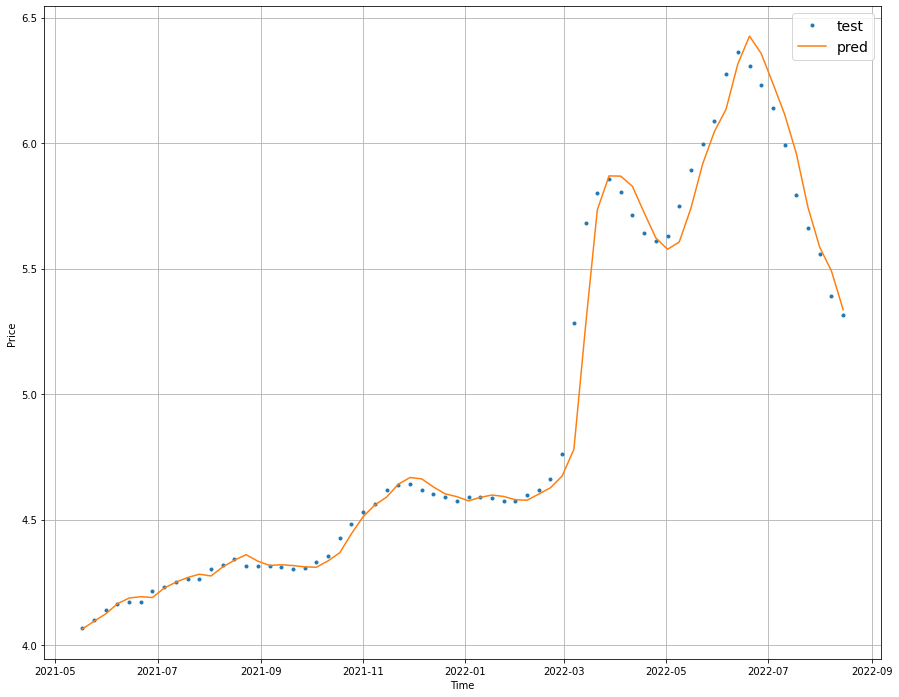

In [ ]:
plt.figure(figsize=(15,12))
plot_time_series(X_test.index,y_test,start=50,label='test')
plot_time_series(X_test.index,model1_result[0],start=50,label='pred',format='-')

# Model2: Simple Dense Model(window=4, horizon=1)

In [ ]:
horizon=1
window=4

In [ ]:
price_window4=price.copy()
for i in range(window):
  price_window4[f"{i+1} unit ago"] = price_window4["Price"].shift(periods=i+1)
price_window4.head()

,Price,1 unit ago,2 unit ago,3 unit ago,4 unit ago
Date,,,,,
2000-05-22,1.679,NaN,NaN,NaN,NaN
2000-05-29,1.673,1.679,NaN,NaN,NaN
2000-06-05,1.661,1.673,1.679,NaN,NaN
2000-06-12,1.662,1.661,1.673,1.679,NaN
2000-06-19,1.664,1.662,1.661,1.673,1.679


In [ ]:
X2 = price_window4.dropna().drop("Price", axis=1).astype(np.float32) 
y2 = price_window4.dropna()["Price"].astype(np.float32)
X2.head()

,1 unit ago,2 unit ago,3 unit ago,4 unit ago
Date,,,,
2000-06-19,1.662,1.661,1.673,1.679
2000-06-26,1.664,1.662,1.661,1.673
2000-07-03,1.687,1.664,1.662,1.661
2000-07-10,1.754,1.687,1.664,1.662
2000-07-17,1.773,1.754,1.687,1.664


In [ ]:
split_size = int(len(X2) * 0.9)
X_train2, y_train2 = X2[:split_size], y2[:split_size]
X_test2, y_test2 = X2[split_size:], y2[split_size:]
X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape

((1041, 4), (1041,), (116, 4), (116,))

## Create and Fit Model

In [ ]:
tf.random.set_seed(1)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(horizon, activation="linear")                       
], name="model_2_dense") 

model_2.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae']) 

model_2.fit(x=X_train2,
            y=y_train2, 
            epochs=100,
            verbose=1,
            batch_size=32,
            validation_data=(X_test2,y_test2),
            callbacks=[model_checkpoint(model_name=model_2.name)]) 

Epoch 1/100
20/33 [=================>............] - ETA: 0s - loss: 5.0173 - mae: 2.0782 
Epoch 1: val_loss improved from inf to 0.19918, saving model to experiments/model_2_dense
33/33 [==============================] - 1s 18ms/step - loss: 3.2877 - mae: 1.5250 - val_loss: 0.1992 - val_mae: 0.4006
Epoch 2/100
19/33 [================>.............] - ETA: 0s - loss: 0.0440 - mae: 0.1716
Epoch 2: val_loss improved from 0.19918 to 0.02759, saving model to experiments/model_2_dense
33/33 [==============================] - 0s 14ms/step - loss: 0.0435 - mae: 0.1726 - val_loss: 0.0276 - val_mae: 0.0965
Epoch 3/100
20/33 [=================>............] - ETA: 0s - loss: 0.0194 - mae: 0.1044
Epoch 3: val_loss did not improve from 0.02759
33/33 [==============================] - 0s 4ms/step - loss: 0.0198 - mae: 0.1047 - val_loss: 0.0455 - val_mae: 0.1462
Epoch 4/100
20/33 [=================>............] - ETA: 0s - loss: 0.0213 - mae: 0.1070
Epoch 4: val_loss did not improve from 0.02759
33

## Evaluation

In [ ]:
model_2.evaluate(X_test2,y_test2)

4/4 [==============================] - 0s 3ms/step - loss: 0.0069 - mae: 0.0438


[0.006853871513158083, 0.0438157357275486]

In [ ]:
model2=tf.keras.models.load_model('experiments/model_2_dense')

In [ ]:
model2_result=predict_and_evaluate(model2, X_test2, y_test2)
model2_result[1]

{'mae': 0.043094434,
 'mse': 0.006756832,
 'rmse': 0.082199946,
 'mape': 0.89022917}

## Visualization

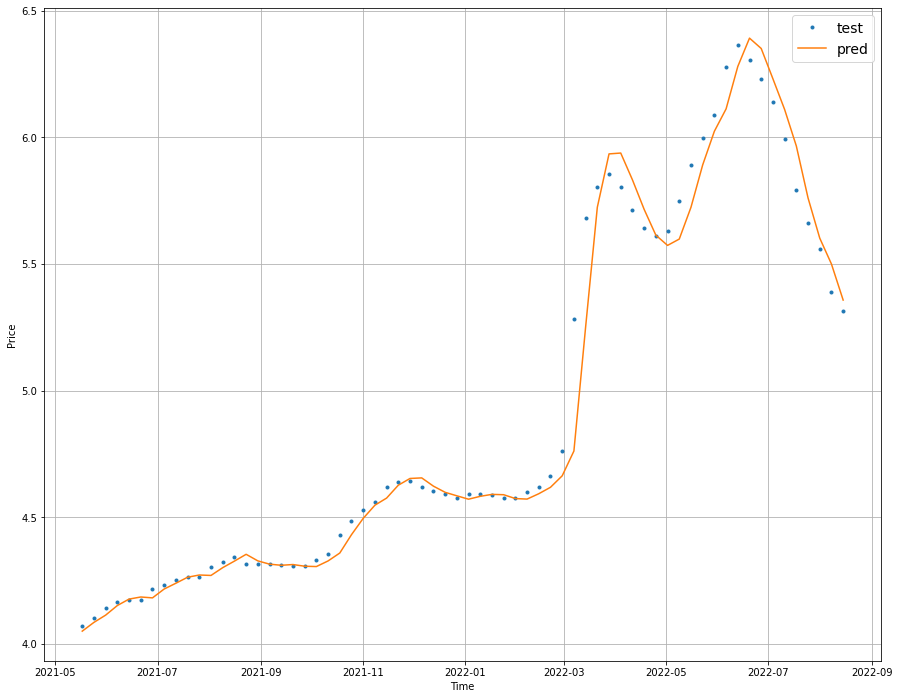

In [ ]:
plt.figure(figsize=(15,12))
plot_time_series(X_test2.index,y_test2,start=50,label='test')
plot_time_series(X_test2.index,model2_result[0],start=50,label='pred',format='-')

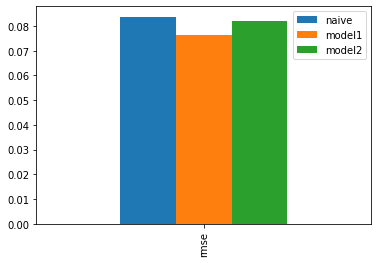

In [ ]:
pd.DataFrame({"naive":naive_result['rmse'],
              "model1": model1_result[1]['rmse'],
              "model2": model2_result[1]['rmse']},index=['rmse']).plot(kind='bar')
plt.show()

# Model3: con1d

In [ ]:
horizon=1
window=7

In [ ]:
tf.random.set_seed(1)
model_3 = tf.keras.Sequential([
  layers.Lambda(lambda x: tf.expand_dims(x,axis=1)),
  layers.Conv1D(filters=128,kernel_size=5,padding='causal'),
  layers.Dense(horizon, activation="linear")                       
], name="model_3_conv1d") 

model_3.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae']) 

model_3.fit(x=X_train,
            y=y_train, 
            epochs=100,
            verbose=1,
            batch_size=32,
            validation_data=(X_test,y_test),
            callbacks=[model_checkpoint(model_name=model_3.name)]) 

Epoch 1/100
31/33 [===========================>..] - ETA: 0s - loss: 1.2740 - mae: 0.8034
Epoch 1: val_loss improved from inf to 0.38115, saving model to experiments/model_3_conv1d
33/33 [==============================] - 1s 25ms/step - loss: 1.2214 - mae: 0.7785 - val_loss: 0.3811 - val_mae: 0.5528
Epoch 2/100
17/33 [==============>...............] - ETA: 0s - loss: 0.0921 - mae: 0.2375
Epoch 2: val_loss improved from 0.38115 to 0.12010, saving model to experiments/model_3_conv1d
33/33 [==============================] - 1s 21ms/step - loss: 0.0729 - mae: 0.2062 - val_loss: 0.1201 - val_mae: 0.2673
Epoch 3/100
17/33 [==============>...............] - ETA: 0s - loss: 0.0495 - mae: 0.1612
Epoch 3: val_loss improved from 0.12010 to 0.08876, saving model to experiments/model_3_conv1d
33/33 [==============================] - 1s 21ms/step - loss: 0.0477 - mae: 0.1623 - val_loss: 0.0888 - val_mae: 0.2079
Epoch 4/100
17/33 [==============>...............] - ETA: 0s - loss: 0.0512 - mae: 0.1666

## Evaluation

In [ ]:
model3=tf.keras.models.load_model('experiments/model_3_conv1d')

In [ ]:
model3_result=predict_and_evaluate(model3, X_test, y_test)
model3_result[1]

{'mae': 0.041997895,
 'mse': 0.006410375,
 'rmse': 0.08006482,
 'mape': 0.87501323}

# Model4: LSTM

In [ ]:
tf.random.set_seed(1)
inputs = layers.Input(shape=(window))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) 
x = layers.LSTM(128, activation="relu")(x)
output = layers.Dense(horizon)(x)
model_4 = tf.keras.Model(inputs=inputs, outputs=output, name="model_4_lstm")


model_4.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

model_4.fit(X_train,
            y_train,
            epochs=100,
            verbose=1,
            batch_size=32,
            validation_data=(X_test, y_test),
            callbacks=[model_checkpoint(model_name=model_4.name)])

Epoch 1/100
28/33 [========================>.....] - ETA: 0s - loss: 5.0259 - mae: 2.1051
Epoch 1: val_loss improved from inf to 0.37630, saving model to experiments/model_4_lstm


33/33 [==============================] - 3s 62ms/step - loss: 4.4482 - mae: 1.9347 - val_loss: 0.3763 - val_mae: 0.5699
Epoch 2/100
29/33 [=========================>....] - ETA: 0s - loss: 0.1812 - mae: 0.3430
Epoch 2: val_loss did not improve from 0.37630
33/33 [==============================] - 0s 6ms/step - loss: 0.1741 - mae: 0.3367 - val_loss: 0.3785 - val_mae: 0.4264
Epoch 3/100
27/33 [=======================>......] - ETA: 0s - loss: 0.1143 - mae: 0.2874
Epoch 3: val_loss did not improve from 0.37630
33/33 [==============================] - 0s 7ms/step - loss: 0.1150 - mae: 0.2875 - val_loss: 0.4409 - val_mae: 0.4505
Epoch 4/100
28/33 [========================>.....] - ETA: 0s - loss: 0.1059 - mae: 0.2725
Epoch 4: val_loss did not improve from 0.37630
33/33 [==============================] - 0s 7ms/step - loss: 0.1034 - mae: 0.2689 - val_loss: 0.4179 - val_mae: 0.4365
Epoch 5/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0955 - mae: 0.2580
Epoch 5: val_loss impr

33/33 [==============================] - 2s 53ms/step - loss: 0.0953 - mae: 0.2575 - val_loss: 0.3731 - val_mae: 0.4120
Epoch 6/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0863 - mae: 0.2429
Epoch 6: val_loss improved from 0.37314 to 0.24565, saving model to experiments/model_4_lstm


33/33 [==============================] - 2s 52ms/step - loss: 0.0862 - mae: 0.2424 - val_loss: 0.2457 - val_mae: 0.3410
Epoch 7/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0777 - mae: 0.2296
Epoch 7: val_loss improved from 0.24565 to 0.23825, saving model to experiments/model_4_lstm


33/33 [==============================] - 2s 52ms/step - loss: 0.0769 - mae: 0.2289 - val_loss: 0.2382 - val_mae: 0.3308
Epoch 8/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0680 - mae: 0.2112
Epoch 8: val_loss improved from 0.23825 to 0.15967, saving model to experiments/model_4_lstm


33/33 [==============================] - 2s 53ms/step - loss: 0.0678 - mae: 0.2111 - val_loss: 0.1597 - val_mae: 0.2724
Epoch 9/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0575 - mae: 0.1924
Epoch 9: val_loss improved from 0.15967 to 0.12180, saving model to experiments/model_4_lstm


33/33 [==============================] - 2s 53ms/step - loss: 0.0581 - mae: 0.1932 - val_loss: 0.1218 - val_mae: 0.2348
Epoch 10/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0492 - mae: 0.1767
Epoch 10: val_loss improved from 0.12180 to 0.08471, saving model to experiments/model_4_lstm


33/33 [==============================] - 2s 53ms/step - loss: 0.0486 - mae: 0.1755 - val_loss: 0.0847 - val_mae: 0.1922
Epoch 11/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0416 - mae: 0.1589
Epoch 11: val_loss improved from 0.08471 to 0.05906, saving model to experiments/model_4_lstm


33/33 [==============================] - 2s 53ms/step - loss: 0.0407 - mae: 0.1577 - val_loss: 0.0591 - val_mae: 0.1675
Epoch 12/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0366 - mae: 0.1477
Epoch 12: val_loss improved from 0.05906 to 0.05807, saving model to experiments/model_4_lstm


33/33 [==============================] - 2s 53ms/step - loss: 0.0358 - mae: 0.1461 - val_loss: 0.0581 - val_mae: 0.1540
Epoch 13/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0327 - mae: 0.1371
Epoch 13: val_loss improved from 0.05807 to 0.04160, saving model to experiments/model_4_lstm


33/33 [==============================] - 2s 54ms/step - loss: 0.0318 - mae: 0.1345 - val_loss: 0.0416 - val_mae: 0.1348
Epoch 14/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0272 - mae: 0.1228
Epoch 14: val_loss improved from 0.04160 to 0.03776, saving model to experiments/model_4_lstm


33/33 [==============================] - 2s 53ms/step - loss: 0.0271 - mae: 0.1219 - val_loss: 0.0378 - val_mae: 0.1245
Epoch 15/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0236 - mae: 0.1151
Epoch 15: val_loss did not improve from 0.03776
33/33 [==============================] - 0s 7ms/step - loss: 0.0245 - mae: 0.1154 - val_loss: 0.0386 - val_mae: 0.1280
Epoch 16/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0219 - mae: 0.1090
Epoch 16: val_loss improved from 0.03776 to 0.02848, saving model to experiments/model_4_lstm


33/33 [==============================] - 2s 54ms/step - loss: 0.0226 - mae: 0.1102 - val_loss: 0.0285 - val_mae: 0.0997
Epoch 17/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0193 - mae: 0.1044
Epoch 17: val_loss did not improve from 0.02848
33/33 [==============================] - 0s 7ms/step - loss: 0.0210 - mae: 0.1065 - val_loss: 0.0526 - val_mae: 0.1670
Epoch 18/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0199 - mae: 0.1039
Epoch 18: val_loss did not improve from 0.02848
33/33 [==============================] - 0s 7ms/step - loss: 0.0204 - mae: 0.1046 - val_loss: 0.0298 - val_mae: 0.1031
Epoch 19/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0192 - mae: 0.1011
Epoch 19: val_loss did not improve from 0.02848
33/33 [==============================] - 0s 7ms/step - loss: 0.0192 - mae: 0.1013 - val_loss: 0.0289 - val_mae: 0.1025
Epoch 20/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0183 - mae: 0.0999
Epoch 20: val_l

33/33 [==============================] - 2s 54ms/step - loss: 0.0142 - mae: 0.0869 - val_loss: 0.0237 - val_mae: 0.0901
Epoch 25/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0145 - mae: 0.0879
Epoch 25: val_loss did not improve from 0.02370
33/33 [==============================] - 0s 7ms/step - loss: 0.0142 - mae: 0.0874 - val_loss: 0.0403 - val_mae: 0.1475
Epoch 26/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0134 - mae: 0.0839
Epoch 26: val_loss did not improve from 0.02370
33/33 [==============================] - 0s 6ms/step - loss: 0.0131 - mae: 0.0832 - val_loss: 0.0248 - val_mae: 0.0973
Epoch 27/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0118 - mae: 0.0794
Epoch 27: val_loss improved from 0.02370 to 0.01979, saving model to experiments/model_4_lstm


33/33 [==============================] - 4s 122ms/step - loss: 0.0126 - mae: 0.0814 - val_loss: 0.0198 - val_mae: 0.0784
Epoch 28/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0121 - mae: 0.0791
Epoch 28: val_loss improved from 0.01979 to 0.01827, saving model to experiments/model_4_lstm


33/33 [==============================] - 2s 53ms/step - loss: 0.0123 - mae: 0.0802 - val_loss: 0.0183 - val_mae: 0.0743
Epoch 29/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0113 - mae: 0.0772
Epoch 29: val_loss improved from 0.01827 to 0.01478, saving model to experiments/model_4_lstm


33/33 [==============================] - 2s 53ms/step - loss: 0.0116 - mae: 0.0777 - val_loss: 0.0148 - val_mae: 0.0719
Epoch 30/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0127 - mae: 0.0827
Epoch 30: val_loss did not improve from 0.01478
33/33 [==============================] - 0s 7ms/step - loss: 0.0126 - mae: 0.0830 - val_loss: 0.0494 - val_mae: 0.1760
Epoch 31/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0120 - mae: 0.0795
Epoch 31: val_loss did not improve from 0.01478
33/33 [==============================] - 0s 7ms/step - loss: 0.0115 - mae: 0.0783 - val_loss: 0.0279 - val_mae: 0.1146
Epoch 32/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0113 - mae: 0.0778
Epoch 32: val_loss did not improve from 0.01478
33/33 [==============================] - 0s 6ms/step - loss: 0.0109 - mae: 0.0766 - val_loss: 0.0184 - val_mae: 0.0761
Epoch 33/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0102 - mae: 0.0732
Epoch 33: val_l

33/33 [==============================] - 2s 52ms/step - loss: 0.0105 - mae: 0.0743 - val_loss: 0.0146 - val_mae: 0.0734
Epoch 36/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0103 - mae: 0.0743
Epoch 36: val_loss did not improve from 0.01462
33/33 [==============================] - 0s 7ms/step - loss: 0.0105 - mae: 0.0749 - val_loss: 0.0189 - val_mae: 0.0773
Epoch 37/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0097 - mae: 0.0710
Epoch 37: val_loss did not improve from 0.01462
33/33 [==============================] - 0s 7ms/step - loss: 0.0098 - mae: 0.0715 - val_loss: 0.0216 - val_mae: 0.0894
Epoch 38/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0097 - mae: 0.0717
Epoch 38: val_loss did not improve from 0.01462
33/33 [==============================] - 0s 7ms/step - loss: 0.0099 - mae: 0.0720 - val_loss: 0.0154 - val_mae: 0.0675
Epoch 39/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0100 - mae: 0.0724
Epoch 39: val_l

33/33 [==============================] - 2s 53ms/step - loss: 0.0082 - mae: 0.0646 - val_loss: 0.0145 - val_mae: 0.0800
Epoch 56/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0096 - mae: 0.0714
Epoch 56: val_loss did not improve from 0.01453
33/33 [==============================] - 0s 7ms/step - loss: 0.0093 - mae: 0.0700 - val_loss: 0.0163 - val_mae: 0.0698
Epoch 57/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0081 - mae: 0.0644
Epoch 57: val_loss did not improve from 0.01453
33/33 [==============================] - 0s 7ms/step - loss: 0.0079 - mae: 0.0642 - val_loss: 0.0307 - val_mae: 0.1240
Epoch 58/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0081 - mae: 0.0646
Epoch 58: val_loss did not improve from 0.01453
33/33 [==============================] - 0s 6ms/step - loss: 0.0080 - mae: 0.0642 - val_loss: 0.0155 - val_mae: 0.0675
Epoch 59/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0081 - mae: 0.0645
Epoch 59: val_l

33/33 [==============================] - 2s 54ms/step - loss: 0.0080 - mae: 0.0655 - val_loss: 0.0136 - val_mae: 0.0695
Epoch 64/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0080 - mae: 0.0655
Epoch 64: val_loss did not improve from 0.01365
33/33 [==============================] - 0s 7ms/step - loss: 0.0079 - mae: 0.0651 - val_loss: 0.0171 - val_mae: 0.0735
Epoch 65/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0074 - mae: 0.0610
Epoch 65: val_loss did not improve from 0.01365
33/33 [==============================] - 0s 7ms/step - loss: 0.0074 - mae: 0.0610 - val_loss: 0.0179 - val_mae: 0.0761
Epoch 66/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0072 - mae: 0.0611
Epoch 66: val_loss did not improve from 0.01365
33/33 [==============================] - 0s 7ms/step - loss: 0.0075 - mae: 0.0617 - val_loss: 0.0145 - val_mae: 0.0668
Epoch 67/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0074 - mae: 0.0615
Epoch 67: val_l

33/33 [==============================] - 2s 55ms/step - loss: 0.0073 - mae: 0.0612 - val_loss: 0.0136 - val_mae: 0.0652
Epoch 78/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0072 - mae: 0.0605
Epoch 78: val_loss did not improve from 0.01358
33/33 [==============================] - 0s 7ms/step - loss: 0.0069 - mae: 0.0596 - val_loss: 0.0146 - val_mae: 0.0665
Epoch 79/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0069 - mae: 0.0591
Epoch 79: val_loss did not improve from 0.01358
33/33 [==============================] - 0s 6ms/step - loss: 0.0068 - mae: 0.0589 - val_loss: 0.0167 - val_mae: 0.0735
Epoch 80/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0068 - mae: 0.0586
Epoch 80: val_loss improved from 0.01358 to 0.01318, saving model to experiments/model_4_lstm


33/33 [==============================] - 2s 55ms/step - loss: 0.0068 - mae: 0.0592 - val_loss: 0.0132 - val_mae: 0.0646
Epoch 81/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0072 - mae: 0.0606
Epoch 81: val_loss did not improve from 0.01318
33/33 [==============================] - 0s 6ms/step - loss: 0.0073 - mae: 0.0607 - val_loss: 0.0199 - val_mae: 0.0857
Epoch 82/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0067 - mae: 0.0583
Epoch 82: val_loss did not improve from 0.01318
33/33 [==============================] - 0s 7ms/step - loss: 0.0068 - mae: 0.0587 - val_loss: 0.0150 - val_mae: 0.0678
Epoch 83/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0064 - mae: 0.0574
Epoch 83: val_loss did not improve from 0.01318
33/33 [==============================] - 0s 7ms/step - loss: 0.0065 - mae: 0.0571 - val_loss: 0.0174 - val_mae: 0.0767
Epoch 84/100
31/33 [===========================>..] - ETA: 0s - loss: 0.0062 - mae: 0.0558
Epoch 84: val_l

33/33 [==============================] - 2s 54ms/step - loss: 0.0074 - mae: 0.0642 - val_loss: 0.0127 - val_mae: 0.0633
Epoch 86/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0066 - mae: 0.0571
Epoch 86: val_loss did not improve from 0.01268
33/33 [==============================] - 0s 7ms/step - loss: 0.0063 - mae: 0.0559 - val_loss: 0.0216 - val_mae: 0.0933
Epoch 87/100
27/33 [=======================>......] - ETA: 0s - loss: 0.0063 - mae: 0.0560
Epoch 87: val_loss did not improve from 0.01268
33/33 [==============================] - 0s 7ms/step - loss: 0.0062 - mae: 0.0556 - val_loss: 0.0170 - val_mae: 0.0754
Epoch 88/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0064 - mae: 0.0551
Epoch 88: val_loss did not improve from 0.01268
33/33 [==============================] - 0s 6ms/step - loss: 0.0063 - mae: 0.0551 - val_loss: 0.0143 - val_mae: 0.0660
Epoch 89/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0065 - mae: 0.0571
Epoch 89: val_l

33/33 [==============================] - 2s 54ms/step - loss: 0.0063 - mae: 0.0563 - val_loss: 0.0125 - val_mae: 0.0622
Epoch 90/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0061 - mae: 0.0553
Epoch 90: val_loss improved from 0.01248 to 0.01233, saving model to experiments/model_4_lstm


33/33 [==============================] - 2s 53ms/step - loss: 0.0062 - mae: 0.0561 - val_loss: 0.0123 - val_mae: 0.0640
Epoch 91/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0063 - mae: 0.0579
Epoch 91: val_loss did not improve from 0.01233
33/33 [==============================] - 0s 7ms/step - loss: 0.0067 - mae: 0.0596 - val_loss: 0.0245 - val_mae: 0.1046
Epoch 92/100
29/33 [=========================>....] - ETA: 0s - loss: 0.0060 - mae: 0.0555
Epoch 92: val_loss did not improve from 0.01233
33/33 [==============================] - 0s 7ms/step - loss: 0.0061 - mae: 0.0552 - val_loss: 0.0251 - val_mae: 0.1073
Epoch 93/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0064 - mae: 0.0571
Epoch 93: val_loss did not improve from 0.01233
33/33 [==============================] - 0s 7ms/step - loss: 0.0063 - mae: 0.0567 - val_loss: 0.0152 - val_mae: 0.0694
Epoch 94/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0061 - mae: 0.0548
Epoch 94: val_l

33/33 [==============================] - 2s 54ms/step - loss: 0.0067 - mae: 0.0590 - val_loss: 0.0118 - val_mae: 0.0609
Epoch 96/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0064 - mae: 0.0578
Epoch 96: val_loss did not improve from 0.01183
33/33 [==============================] - 0s 7ms/step - loss: 0.0064 - mae: 0.0576 - val_loss: 0.0264 - val_mae: 0.1120
Epoch 97/100
30/33 [==========================>...] - ETA: 0s - loss: 0.0060 - mae: 0.0539
Epoch 97: val_loss did not improve from 0.01183
33/33 [==============================] - 0s 6ms/step - loss: 0.0060 - mae: 0.0544 - val_loss: 0.0178 - val_mae: 0.0797
Epoch 98/100
26/33 [======================>.......] - ETA: 0s - loss: 0.0059 - mae: 0.0544
Epoch 98: val_loss did not improve from 0.01183
33/33 [==============================] - 0s 7ms/step - loss: 0.0059 - mae: 0.0538 - val_loss: 0.0160 - val_mae: 0.0721
Epoch 99/100
28/33 [========================>.....] - ETA: 0s - loss: 0.0061 - mae: 0.0562
Epoch 99: val_l

## Evaluation

In [ ]:
model4=tf.keras.models.load_model('experiments/model_4_lstm')
model4_result=predict_and_evaluate(model4, X_test, y_test)
model4_result[1]

{'mae': 0.060887493, 'mse': 0.011830916, 'rmse': 0.10877001, 'mape': 1.2619784}

# Model5: N-BEATS 

reference paper : https://arxiv.org/pdf/1905.10437.pdf

## Customize NBblock 

In [ ]:
class NBblock(tf.keras.layers.Layer):
  def __init__(self, input_size, theta,horizon,n_neurons,n_layers,**kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta = theta
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # 4 dense layers with relu activation
    self.hidden=[tf.keras.layers.Dense(n_neurons,activation='relu') for i in range(n_layers)]
    # theta layers
    self.theta_layer=tf.keras.layers.Dense(theta, activation='linear',name='theta')

  def call(self,input):
    x = input
    for layer in self.hidden:
      x = layer(x)
    theta_res = self.theta_layer(x) 
    backcast, forecast = theta_res[:, :self.input_size], theta_res[:, -self.horizon:]
    return backcast, forecast




## Prepare Data

In [ ]:
X_train_dt = tf.data.Dataset.from_tensor_slices(X_train)
y_train_dt = tf.data.Dataset.from_tensor_slices(y_train)
X_test_dt = tf.data.Dataset.from_tensor_slices(X_test)
y_test_dt = tf.data.Dataset.from_tensor_slices(y_test)

train = tf.data.Dataset.zip((X_train_dt, y_train_dt))
test= tf.data.Dataset.zip((X_test_dt, y_test_dt))

batch_size = 1024 
train = train.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test= test.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
n_epoch = 5000 
n_neuron = 512 
n_layer= 4
n_stack = 30
input = window * horizon 
theta = input + horizon


## Build and Compile

In [ ]:
tf.random.set_seed(1)

#create first block
initial_NBblock_layer = NBblock(input_size=input,
                                 theta=theta,
                                 horizon=horizon,
                                 n_neurons=n_neuron,
                                 n_layers=n_layer,
                                 name="initial_block")

# create first stack input
stack_input = layers.Input(shape=(input), name="stack_input")

# first backcast and forecast result
backcast, forecast = initial_NBblock_layer(stack_input)

# first residual calculated from first stack_input and first backcast
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# subsequent stacks and residuals calculation
for i, _ in enumerate(range(n_stack-1)): 
  backcast, block_forecast =NBblock(input_size=input,
                                 theta=theta,
                                 horizon=horizon,
                                 n_neurons=n_neuron,
                                 n_layers=n_layer,
                                 name=f"NBeatsBlock_{i}")(residuals) 

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  # aggregate forcast
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model_5 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_5_NBEATS")


model_5.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae"])


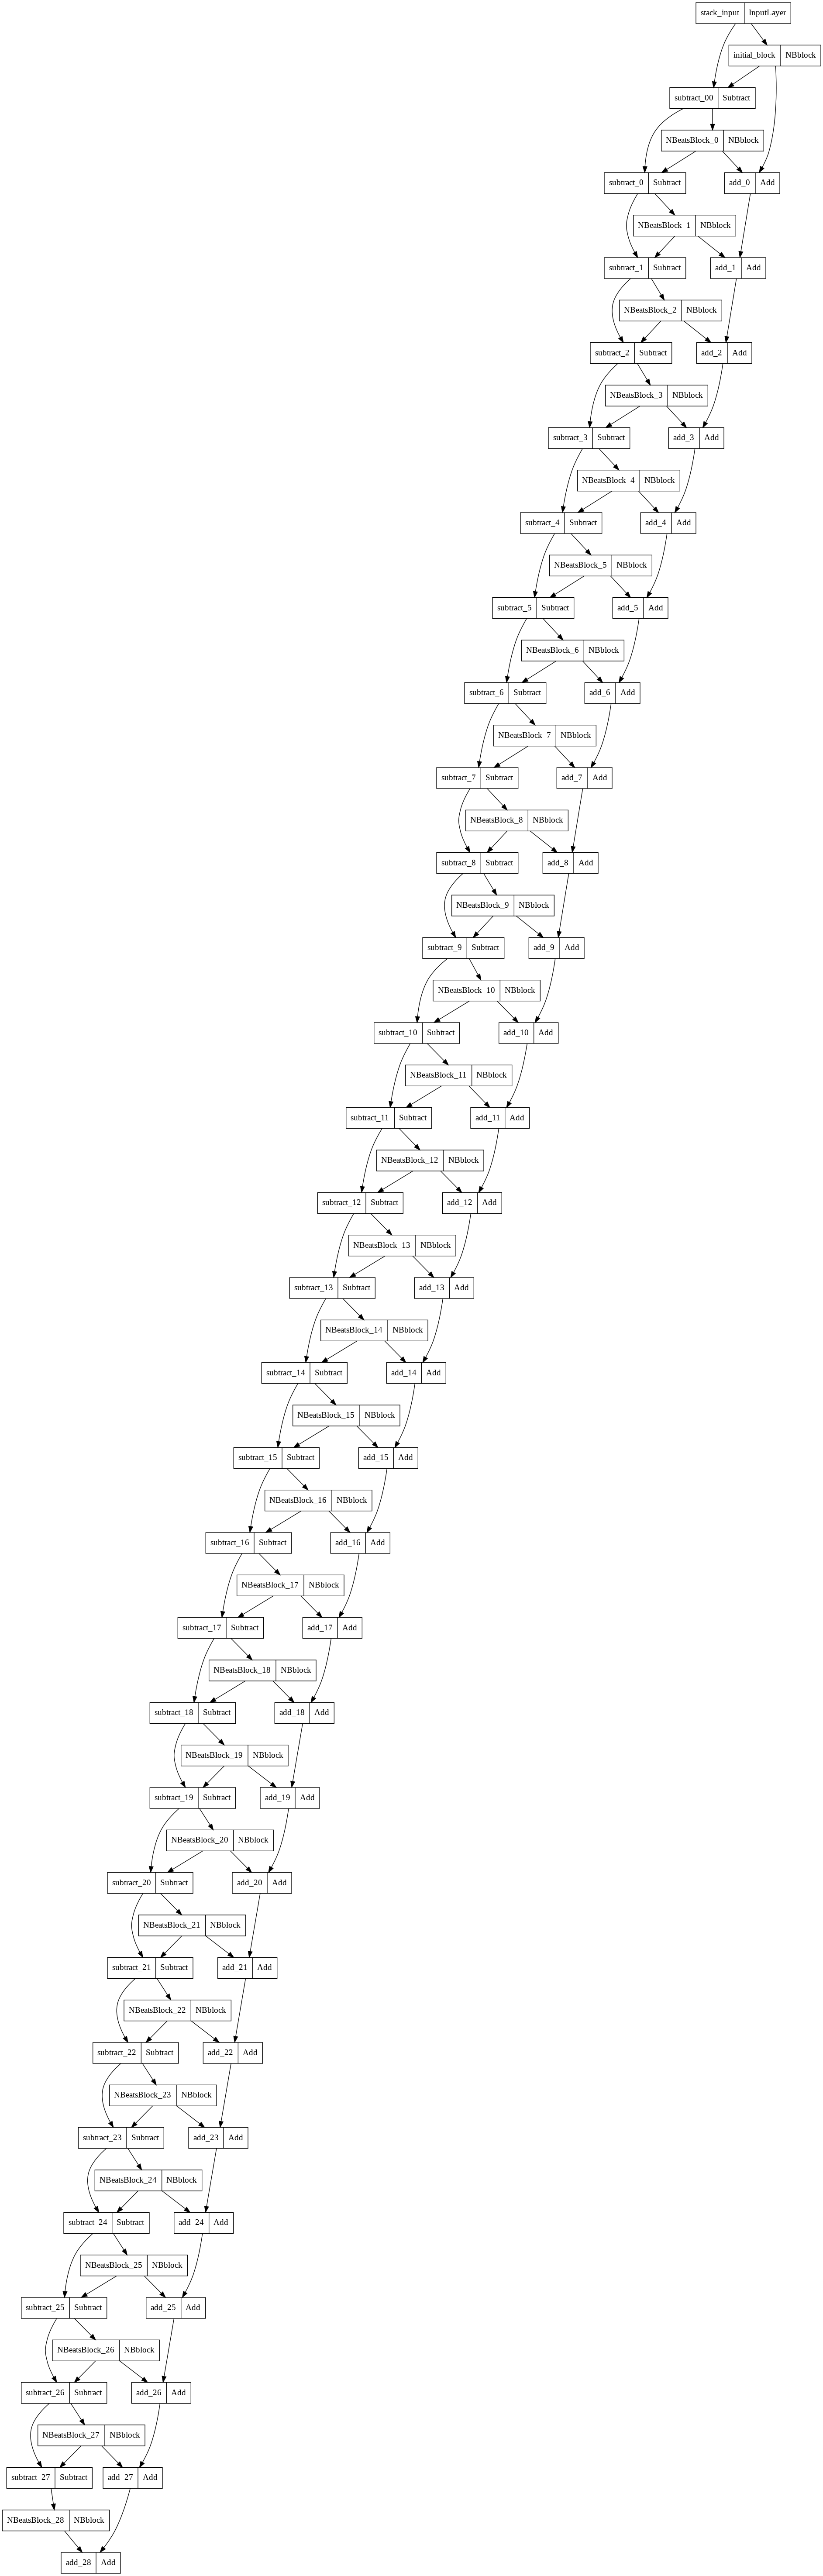

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [ ]:
model_5.fit(train,
            epochs=n_epoch,
            validation_data=test,
            verbose=0, 
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1,factor=0.5)])


Epoch 148: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 248: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


In [ ]:
model5_result=predict_and_evaluate(model_5, X_test, y_test)
model5_result[1]

{'mae': 0.03273809,
 'mse': 0.0033647793,
 'rmse': 0.058006715,
 'mape': 0.72250867}

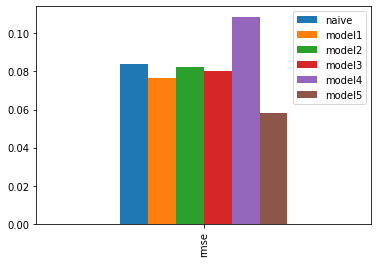

In [ ]:
pd.DataFrame({"naive":naive_result['rmse'],
              "model1": model1_result[1]['rmse'],
              "model2": model2_result[1]['rmse'],
              "model3": model3_result[1]['rmse'],
              "model4": model4_result[1]['rmse'],
              "model5": model5_result[1]['rmse']},index=['rmse']).plot(kind='bar')
plt.show()

# model6 ensemble method

## Create Ensamble Method

In [ ]:
def make_ensemble_models(horizon=horizon, 
                        train_data=train,
                        test_data=test,
                        num_epochs=1000, 
                        potential_models=[model1,model3,model_5],
                        extra=0):
  ensemble_models=[]
  if(extra>0):
    for i in range(extra):
       model = tf.keras.Sequential([
         layers.Dense(128, activation="relu", kernel_initializer="RandomNormal"),  
         layers.Dense(horizon)                                
       ])
       potential_models.append(model)

  for model in potential_models:
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
    model.fit(train_data,
              epochs=num_epochs,
              verbose=0,
              validation_data=test_data,
              batch_size=32,
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                          tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=0)])
    ensemble_models.append(model)
      
  return ensemble_models


In [ ]:
%%time
ensemble_models = make_ensemble_models(extra=20)

CPU times: user 2min 34s, sys: 11.4 s, total: 2min 45s
Wall time: 2min 30s


In [ ]:
ensemble_models

## Prediction

In [ ]:
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = np.squeeze(model.predict(data))
    ensemble_preds.append(preds)
  return tf.squeeze(ensemble_preds)

In [ ]:
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test)
ensemble_preds[:,:5]

<tf.Tensor: shape=(23, 5), dtype=float32, numpy=
array([[2.8811328, 2.9276452, 2.976977 , 3.0195756, 3.0607054],
       [3.1022453, 3.1217139, 3.1360283, 3.1512432, 3.1662195],
       [2.9253466, 2.956773 , 3.011569 , 3.0573244, 3.0978863],
       [2.8746483, 2.879065 , 2.9053903, 2.9414446, 2.9864895],
       [2.8522835, 2.8511689, 2.8692229, 2.903139 , 2.9444537],
       [2.8473554, 2.8553798, 2.874364 , 2.9079032, 2.9475126],
       [2.86378  , 2.8782506, 2.9031882, 2.937503 , 2.978089 ],
       [2.871428 , 2.870797 , 2.8874357, 2.9149768, 2.9566166],
       [2.8855646, 2.890535 , 2.9091759, 2.9398692, 2.9810748],
       [2.897591 , 2.9063692, 2.9322405, 2.9673157, 3.009141 ],
       [2.8961365, 2.9018717, 2.923684 , 2.9583745, 3.0021892],
       [2.89305  , 2.8999033, 2.9225693, 2.9548466, 2.9948878],
       [2.892968 , 2.897755 , 2.9186995, 2.9554355, 2.9970675],
       [2.8546512, 2.8679068, 2.8912096, 2.9292357, 2.9688168],
       [2.9076657, 2.9179251, 2.9382343, 2.970569 , 3.0

In [ ]:
ensemble_results = evaluate(y_true=np.squeeze(y_test),
                            y_pred=np.mean(ensemble_preds,axis=0)) 
ensemble_results

{'mae': 0.11950594, 'mse': 0.03964961, 'rmse': 0.19912209, 'mape': 2.5620337}

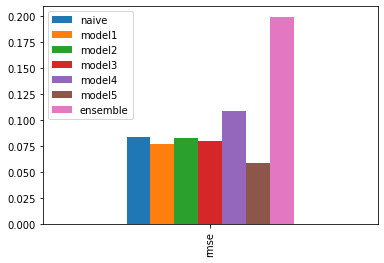

In [ ]:
pd.DataFrame({"naive":naive_result['rmse'],
              "model1": model1_result[1]['rmse'],
              "model2": model2_result[1]['rmse'],
              "model3": model3_result[1]['rmse'],
              "model4": model4_result[1]['rmse'],
              "model5": model5_result[1]['rmse'],
              "ensemble": ensemble_results['rmse']},index=['rmse']).plot(kind='bar')
plt.show()

## Plot Confidence Interval

In [ ]:
import scipy

In [ ]:
def bounds(preds,conf): 
  t=-scipy.stats.t.ppf(q=(1-conf)/2,df=len(preds[0]))
  std = tf.math.reduce_std(preds, axis=0)
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - t * std, preds_mean + t * std
  return lower, upper
lower, upper = bounds(ensemble_preds,0.95)

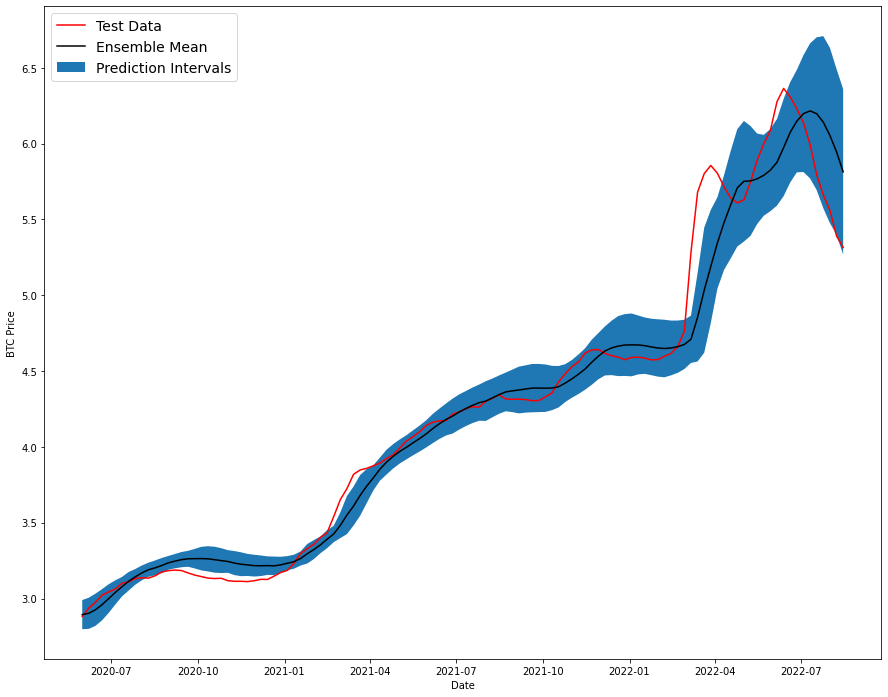

In [ ]:
ensemble_mean = np.mean(ensemble_preds, axis=0)

plt.figure(figsize=(15, 12))
plt.plot(X_test.index, y_test, "r-", label="Test Data")
plt.plot(X_test.index, ensemble_mean, "k-", label="Ensemble Mean")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index, 
                 (lower), 
                 (upper), label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

# Future Prediction Using Model5

In [ ]:
def model_checkpoint2(model_name, save_path="future"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), 
                                            verbose=0,
                                            monitor='loss',
                                            save_best_only=True) 

In [ ]:
model_5.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])
model_5.fit(X,y,
            epochs=n_epoch,
            verbose=0, 
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", patience=100, verbose=1,factor=0.5)])


Epoch 205: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 497: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 864: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 964: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


In [ ]:
into_future=4

In [ ]:
def make_future_forecast(values, model, into_future, window_size=window):

  future_forecast = []
  last_window = values[-window_size:] 
  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-window_size:]
  return future_forecast

In [ ]:
future_forecast = make_future_forecast(values=y,
                                       model=model_5,
                                       into_future=into_future)

In [ ]:
def get_future_dates(start_date, into_future):
  result=[]
  for i in range(1,into_future+1):
    end=start_date+ datetime.timedelta(days=7*i)
    end.strftime('%m/%d/%Y')
    result.append(end)
  return result

In [ ]:
last_timestep = X.index[-1]
last_timestep

Timestamp('2022-08-15 00:00:00')

In [ ]:
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=into_future)
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, y[-1])

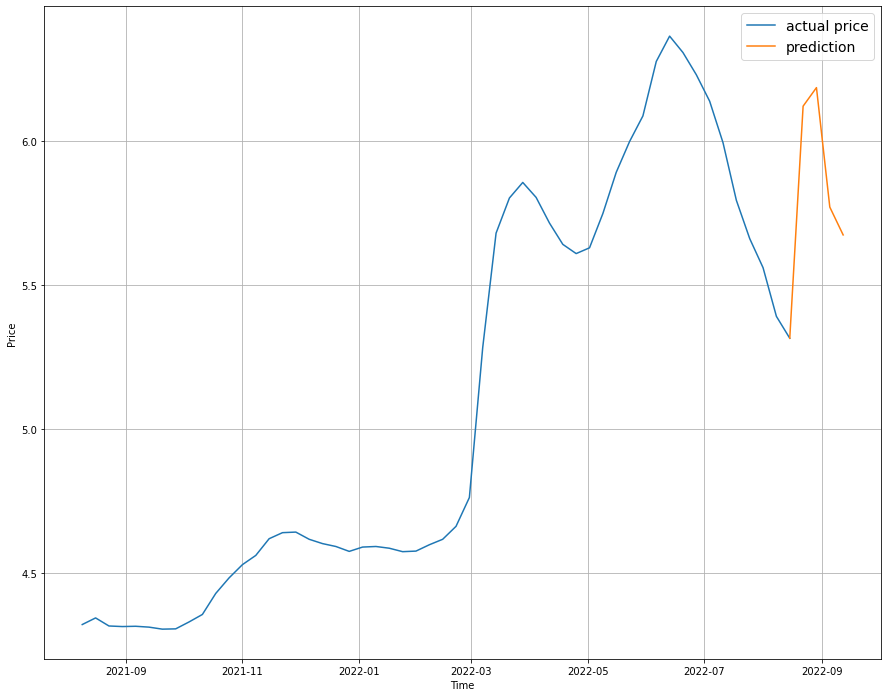

In [ ]:
plt.figure(figsize=(15, 12))
plot_time_series(X.index, y, format="-", start=1100,label="actual price")
plot_time_series(next_time_steps, future_forecast, format="-", label="prediction")